gdown可以下載存放在Google雲端的檔案，類似wget

gdown github: https://github.com/wkentaro/gdown

In [ ]:
# 使用gdown下載資料
!gdown 1bZREL8xxNX4Us5vYtgsg6TomMTdaUARC
!gdown 1PLO60_bOaIYKzyoGyZHqUMv7WckvJBEw

Downloading...
From: https://drive.google.com/uc?id=1bZREL8xxNX4Us5vYtgsg6TomMTdaUARC
To: /content/DJIA_table(train).csv
100% 150k/150k [00:00<00:00, 66.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PLO60_bOaIYKzyoGyZHqUMv7WckvJBEw
To: /content/RedditNews(train).csv
100% 9.10M/9.10M [00:00<00:00, 56.2MB/s]


# 資料集
* 文本資料：每日reddit新聞標題
* 股價資料：道瓊工業平均指數


資料集來源：https://www.kaggle.com/competitions/stock-market-prediction-and-sentimental-analysis/data

# 模型融合的各種型態
![多模態融合的各種形式](https://www.researchgate.net/publication/362028535/figure/fig2/AS:11431281126156761@1678559245845/llustration-of-early-fusion-late-fusion-and-middle-fusion-methods-used-by-multimodal.jpg)

本次作業主要實作的內容是(c)中期融合（Middle Fusion）

# 文本資料處理

In [ ]:
import pandas as pd

# 讀取新聞資料
news_df = pd.read_csv('RedditNews(train).csv', encoding='utf-8')
# 處理掉 b'...' 或 b"..."
# regex 匹配文本:
#   ^b - 比對字串開頭的 'b'
#   ['\"] - 比對單引號或雙引號
#   | - 或者
#   ['\"]$ - 比對字串結尾的單引號或雙引號
news_df['News'] = news_df['News'].str.replace(r"^b['\"]|['\"]$", '', regex=True)
# 印出錢10筆資料
news_df.head(10)

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
5,2016-07-01,Brazil: Huge spike in number of police killing...
6,2016-07-01,Austria's highest court annuls presidential el...
7,2016-07-01,"Facebook wins privacy case, can track any Belg..."
8,2016-07-01,Switzerland denies Muslim girls citizenship af...
9,2016-07-01,China kills millions of innocent meditators fo...


In [ ]:
# 查看每日新聞數量
date_counts = news_df['Date'].value_counts().reset_index()
# 根據日期排序
date_counts.sort_values(by='Date', ascending=True)

,Date,count
928,2008-06-08,25
997,2008-06-09,25
996,2008-06-10,25
1007,2008-06-11,25
994,2008-06-12,25
...,...,...
1214,2016-06-27,25
1928,2016-06-28,25
998,2016-06-29,25
1006,2016-06-30,25


In [ ]:
# 將每日新聞標題合併成一則新聞
news_dict = news_df.groupby('Date')['News'].apply(list).to_dict()
news_dict

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 下載 Hugging Face Transformers
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# 初始化 BERT Tokenizer 和 Model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# 設置為評估模式（不訓練）
bert_model.eval()
print('載入 BERT 成功')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

載入 BERT 成功


In [ ]:
# 設置設備（CPU/GPU/MPS）偵測使用什麼設備
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# 將模型移動到訓練設備
bert_model.to(device)
print(f'模型目前使用{device}')

模型目前使用cuda


In [ ]:
date_embeddings = {}

# 逐日期處理
for date, news_list in news_dict.items():
    # 合併當天的所有新聞為一個文本（用空格分隔）
    combined_text = " ".join(news_list)

    # 將文本 Tokenize 並輸入到 BERT
    inputs = tokenizer(combined_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = bert_model(**inputs)
    print(f'{date} done.')

    # 提取 [CLS] Token 的嵌入作為整體表示
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).detach().cpu().numpy()

    # 保存嵌入到字典
    date_embeddings[date] = cls_embedding

2008-06-08 done.
2008-06-09 done.
2008-06-10 done.
2008-06-11 done.
2008-06-12 done.
2008-06-13 done.
2008-06-14 done.
2008-06-15 done.
2008-06-16 done.
2008-06-17 done.
2008-06-18 done.
2008-06-19 done.
2008-06-20 done.
2008-06-21 done.
2008-06-22 done.
2008-06-23 done.
2008-06-24 done.
2008-06-25 done.
2008-06-26 done.
2008-06-27 done.
2008-06-28 done.
2008-06-29 done.
2008-06-30 done.
2008-07-01 done.
2008-07-02 done.
2008-07-03 done.
2008-07-04 done.
2008-07-05 done.
2008-07-06 done.
2008-07-07 done.
2008-07-08 done.
2008-07-09 done.
2008-07-10 done.
2008-07-11 done.
2008-07-12 done.
2008-07-13 done.
2008-07-14 done.
2008-07-15 done.
2008-07-16 done.
2008-07-17 done.
2008-07-18 done.
2008-07-19 done.
2008-07-20 done.
2008-07-21 done.
2008-07-22 done.
2008-07-23 done.
2008-07-24 done.
2008-07-25 done.
2008-07-26 done.
2008-07-27 done.
2008-07-28 done.
2008-07-29 done.
2008-07-30 done.
2008-07-31 done.
2008-08-01 done.
2008-08-02 done.
2008-08-03 done.
2008-08-04 done.
2008-08-05 don

In [ ]:
# 將嵌入轉換為 DataFrame
embedding_df = pd.DataFrame(date_embeddings).T
embedding_df.columns = [f"Embedding_{i}" for i in range(embedding_df.shape[1])]
embedding_df['Date'] = embedding_df.index
embedding_df['Date'] = pd.to_datetime(embedding_df['Date'], format='%Y-%m-%d')
# 印出錢10筆資料
embedding_df.head(10)

,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,Embedding_9,...,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767,Date
2008-06-08,-0.198385,-0.144236,0.069488,-0.116309,-0.580700,-0.079995,0.494757,0.443124,-0.076045,0.114641,...,-0.348483,-0.013811,-0.261851,0.503283,0.217790,-0.336219,-0.541625,0.607868,0.182255,2008-06-08
2008-06-09,-0.373428,-0.108956,0.213794,0.027715,-0.406929,0.005849,0.508953,0.621934,-0.013783,0.037755,...,-0.312271,-0.028168,-0.026072,0.692208,0.319143,-0.068883,-0.479767,0.552667,0.220548,2008-06-09
2008-06-10,-0.298237,0.169268,-0.200818,0.205484,-0.390613,0.222000,0.576172,0.452965,-0.156957,-0.221062,...,-0.314229,-0.113797,-0.081354,0.679748,-0.101922,-0.180870,-0.502713,0.635183,0.308270,2008-06-10
2008-06-11,-0.308372,0.152368,-0.019860,0.143967,-0.314442,-0.107859,0.753128,0.459349,-0.124832,-0.110088,...,-0.180412,0.017787,-0.260838,0.623176,0.150097,-0.012497,-0.511633,0.652203,0.114420,2008-06-11
2008-06-12,-0.311589,-0.231446,0.053513,0.086309,-0.580402,0.112451,0.652200,0.742272,-0.447851,0.139580,...,-0.069649,-0.029915,-0.243500,0.761308,0.002478,0.044297,-0.452780,0.748016,0.203376,2008-06-12
2008-06-13,-0.426811,-0.278478,-0.026197,-0.048785,-0.603455,0.103328,0.442665,0.388249,-0.075060,-0.160268,...,-0.133991,0.147489,-0.398242,0.490477,-0.007113,-0.459362,-0.339614,0.967528,0.153802,2008-06-13
2008-06-14,-0.423142,-0.201393,-0.059159,0.069293,-0.537429,0.277443,0.810042,0.605696,-0.436974,0.041915,...,-0.229241,-0.013497,-0.193860,0.850519,-0.363265,-0.153338,-0.536058,0.615055,-0.023131,2008-06-14
2008-06-15,-0.418540,0.027653,-0.032037,0.210869,-0.439750,-0.228440,0.657617,0.517551,0.045715,0.031138,...,-0.230459,-0.112386,-0.088031,0.676507,0.278952,-0.042537,-0.547856,0.899336,0.310912,2008-06-15
2008-06-16,-0.336062,-0.160597,0.190049,-0.250919,-0.780718,-0.116191,0.706152,0.412468,0.343830,-0.635814,...,-0.242541,-0.119734,-0.315148,0.409416,0.540449,-0.326974,-0.631223,0.750271,0.449715,2008-06-16
2008-06-17,-0.534123,-0.073870,0.082975,0.052447,-0.826066,-0.137178,0.872317,0.619862,-0.152562,0.004205,...,-0.573096,-0.038707,-0.055669,0.818371,-0.152756,-0.220881,-0.610287,0.584515,0.054854,2008-06-17


# 股價資料處理

In [ ]:
# 讀取股價資料
stock_data = pd.read_csv('DJIA_table(train).csv', encoding='utf-8')
# 日期欄位轉換成 datetime 格式
stock_data['Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True)
# 設定日期為索引
stock_data.set_index('Date', inplace=True)
# 根據日期排序
stock_data = stock_data.sort_index()
# 印出前10筆
stock_data.head(10)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11432.08984,11759.95996,11388.04004,11734.32031,212830000,11734.32031
2008-08-11,11729.66992,11867.11035,11675.53027,11782.34961,183190000,11782.34961
2008-08-12,11781.70020,11782.34961,11601.51953,11642.46973,173590000,11642.46973
2008-08-13,11632.80957,11633.78027,11453.33984,11532.95996,182550000,11532.95996
2008-08-14,11532.07031,11718.28027,11450.88965,11615.92969,159790000,11615.92969
2008-08-15,11611.20996,11709.88965,11599.73047,11659.90039,215040000,11659.90039
2008-08-18,11659.65039,11690.42969,11434.12012,11479.38965,156290000,11479.38965
2008-08-19,11478.08984,11478.16992,11318.50000,11348.54981,171580000,11348.54981
2008-08-20,11345.94043,11454.15039,11290.58008,11417.42969,144880000,11417.42969


In [ ]:
'''
將文本資料和數值資料合併根據日期合併
以利後續資料拆分測試集、訓練集
'''

# 只保留收盤價
price_df = stock_data[['Close']]
# 根據日期合併收盤價和嵌入
combined_df = pd.merge(price_df, embedding_df, on='Date')
# 設定日期為索引
combined_df.set_index('Date', inplace=True)
# 根據日期排序
combined_df = combined_df.sort_index()
# 印出前10筆
combined_df.head(10)

,Close,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11734.32031,-0.587835,-0.366375,-0.047286,0.251385,-0.288917,-0.134200,0.502416,0.647066,-0.215660,...,0.163377,-0.142308,-0.011646,-0.165887,0.523895,0.376322,-0.029254,-0.631961,0.825019,0.024389
2008-08-11,11782.34961,-0.372291,-0.073399,-0.045990,-0.246410,-1.007252,-0.439152,0.693775,0.455300,0.493247,...,-0.093508,-0.134052,0.072778,-0.283020,0.313297,0.469278,-0.104069,-0.700979,0.682417,0.643971
2008-08-12,11642.46973,-0.309147,-0.247977,0.048171,0.306066,-0.711929,-0.425101,0.486479,0.383024,-0.224489,...,-0.025536,-0.082164,-0.057128,-0.488836,0.577513,0.601292,-0.270337,-0.483384,0.974845,0.388392
2008-08-13,11532.95996,-0.687628,-0.019728,0.055199,0.091955,-0.584213,-0.226257,0.584099,0.462233,-0.168849,...,-0.081513,-0.413259,0.076321,-0.051562,0.768652,0.410531,-0.003034,-0.753175,0.771645,0.230110
2008-08-14,11615.92969,-0.777364,-0.162012,0.046284,0.115582,-0.646037,-0.119226,0.681137,0.683649,-0.064202,...,0.206974,-0.051016,0.128415,-0.322207,0.751825,-0.066170,-0.232907,-0.651432,0.751075,-0.171825
2008-08-15,11659.90039,-0.738209,-0.010975,0.029411,0.159827,-0.654928,-0.005206,0.793559,0.419815,-0.157837,...,0.039288,-0.265279,-0.167255,-0.094613,0.875694,0.061983,-0.082314,-0.544599,0.632400,0.238414
2008-08-18,11479.38965,-0.302304,-0.176837,0.074325,-0.030866,-0.307285,-0.244708,0.716299,0.628725,-0.589513,...,-0.435481,-0.203127,-0.052375,-0.300021,0.762072,-0.039617,0.077357,-0.752745,0.496075,0.347063
2008-08-19,11348.54981,-0.746435,-0.145463,-0.027559,-0.026808,-0.897140,0.298353,1.170426,0.886130,-0.428304,...,-0.223896,-0.295141,0.058166,-0.415449,0.677329,0.046283,-0.119660,-0.844477,0.733347,-0.089476
2008-08-20,11417.42969,-0.338771,-0.102513,0.150072,0.100435,-0.526808,0.008705,0.769964,0.998814,-0.168159,...,0.063494,-0.284538,-0.098314,-0.235396,0.787472,0.038077,-0.115460,-0.617311,0.838304,0.051625


# 資料標記、滑動窗口

In [ ]:
import numpy as np

# 加入均線（後續標記漲跌用）
def add_MA(df, short_window=5, long_window=20):
    """添加移動平均線"""
    df['MA_short'] = df['Close'].rolling(window=short_window).mean()
    df['MA_long'] = df['Close'].rolling(window=long_window).mean()
    return df

# 標記漲跌
def create_labels(df):
    """根據長短期均線交叉產生標記"""
    # 計算均線
    df = add_MA(df.copy())

    # 標記漲跌：短期均線在長期均線上方為1，下方為0
    df['Target'] = (df['MA_short'] > df['MA_long']).astype(int)

    # 移除包含 NaN 的行（因為計算均線導致的）
    df = df.dropna()

    print("多頭信號（1）數量:", sum(df['Target'] == 1))
    print("空頭信號（0）數量:", sum(df['Target'] == 0))

    return df

# 準備序列資料
def prepare_sequence_data(df, sequence_length=5):
    """準備序列資料"""
    # 分離特徵
    price_cols = ['Close', 'MA_short', 'MA_long']  # 現在包含均線
    news_cols = [col for col in df.columns if col.startswith('Embedding_')]

    X_price, X_news, y = [], [], []

    for i in range(len(df) - sequence_length):
        # 價格序列（包含均線）
        price_seq = df[price_cols].iloc[i:i+sequence_length].values
        X_price.append(price_seq) # 添加至清單中

        # 新聞序列
        news_seq = df[news_cols].iloc[i:i+sequence_length].values
        X_news.append(news_seq) # 添加至清單中

        # 目標值
        y.append(df['Target'].iloc[i+sequence_length]) # 添加至清單中

    return np.array(X_price), np.array(X_news), np.array(y)

'''函數呼叫'''
# 加入均線
combined_df = add_MA(combined_df)

# 使用均線標記漲跌
combined_df = create_labels(combined_df)

# 創建序列資料
X_price, X_news, y = prepare_sequence_data(combined_df, sequence_length=5)

多頭信號（1）數量: 1132
空頭信號（0）數量: 712


In [ ]:
# 切分訓練集和測試集(80%訓練，20%測試)
split_index = int(len(X_price) * 0.8)

# 股價序列
X_price_train = X_price[:split_index]
X_price_test = X_price[split_index:]

# 新聞序列
X_news_train = X_news[:split_index]
X_news_test = X_news[split_index:]

# 目標值（0:跌, 1:漲）
y_train = y[:split_index]
y_test = y[split_index:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 標準化收盤價
price_scaler = MinMaxScaler()
X_price_train_scaled = price_scaler.fit_transform(X_price_train.reshape(-1, 1)).reshape(X_price_train.shape)
X_price_test_scaled = price_scaler.transform(X_price_test.reshape(-1, 1)).reshape(X_price_test.shape)

In [ ]:
# 顯示訓練資料集和測試資料集的大小 (資料筆數, 特徵數)
print('訓練集形狀：', X_price_train_scaled.shape, X_news_train.shape, y_train.shape)
print('測試集形狀：', X_price_test_scaled.shape, X_news_test.shape, y_test.shape)

訓練集形狀： (1471, 5, 3) (1471, 5, 768) (1471,)
測試集形狀： (368, 5, 3) (368, 5, 768) (368,)


# 建立模型

In [ ]:
import tensorflow as tf  # 引入tensorflow框架
from tensorflow.keras.models import Model  # 模型容器
from tensorflow.keras.utils import plot_model  # 繪製模型架構
from tensorflow.keras.layers import (
    Input,  # 輸入層
    LSTM,  # 長短期記憶
    Dense,  # 全鏈接層
    Concatenate,  # 合併層，這邊用來合併文本與數值特徵
    TimeDistributed,  # 為了讓降維時不影響時間維度（窗口）
    Flatten  # 展平層
)

In [ ]:
def build_separate_lstm_model(sequence_length):
    # 股價序列
    price_input = Input(shape=(sequence_length, 3), name='price_input')
    price_lstm = LSTM(32, name='price_lstm')(price_input)

    # 新聞序列
    news_input = Input(shape=(sequence_length, 768), name='news_input')
    news_dense = TimeDistributed(Dense(32), name='news_dense')(news_input)
    news_lstm = LSTM(16, name='news_lstm')(news_dense)

    # 合併
    merged = Concatenate(name='merge')([price_lstm, news_lstm])
    dense = Dense(32, activation='linear', name='dense_layer')(merged)
    output = Dense(1, activation='sigmoid', name='output_layer')(dense)

    # 建立模型
    model = Model(inputs=[price_input, news_input], outputs=output, name='multimodal_model')

    # 編譯模型
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
# 建立模型
multimodal = build_separate_lstm_model(sequence_length=5)
multimodal.summary()

Model: "multimodal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ news_input (InputLayer)   │ (None, 5, 768)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_input (InputLayer)  │ (None, 5, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ news_dense                │ (None, 5, 32)          │         24,608 │ news_input[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_lstm (LSTM)         │ (None, 32)             │          4,608 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ news_lstm (LSTM)          │ (None, 16)             │          3,136 │ news_dense[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merge (Concatenate)       │ (None, 48)             │              0 │ price_lstm[0][0],      │
│                           │                        │                │ news_lstm[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer (Dense)       │ (None, 32)             │          1,568 │ merge[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 1)              │             33 │ dense_layer[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

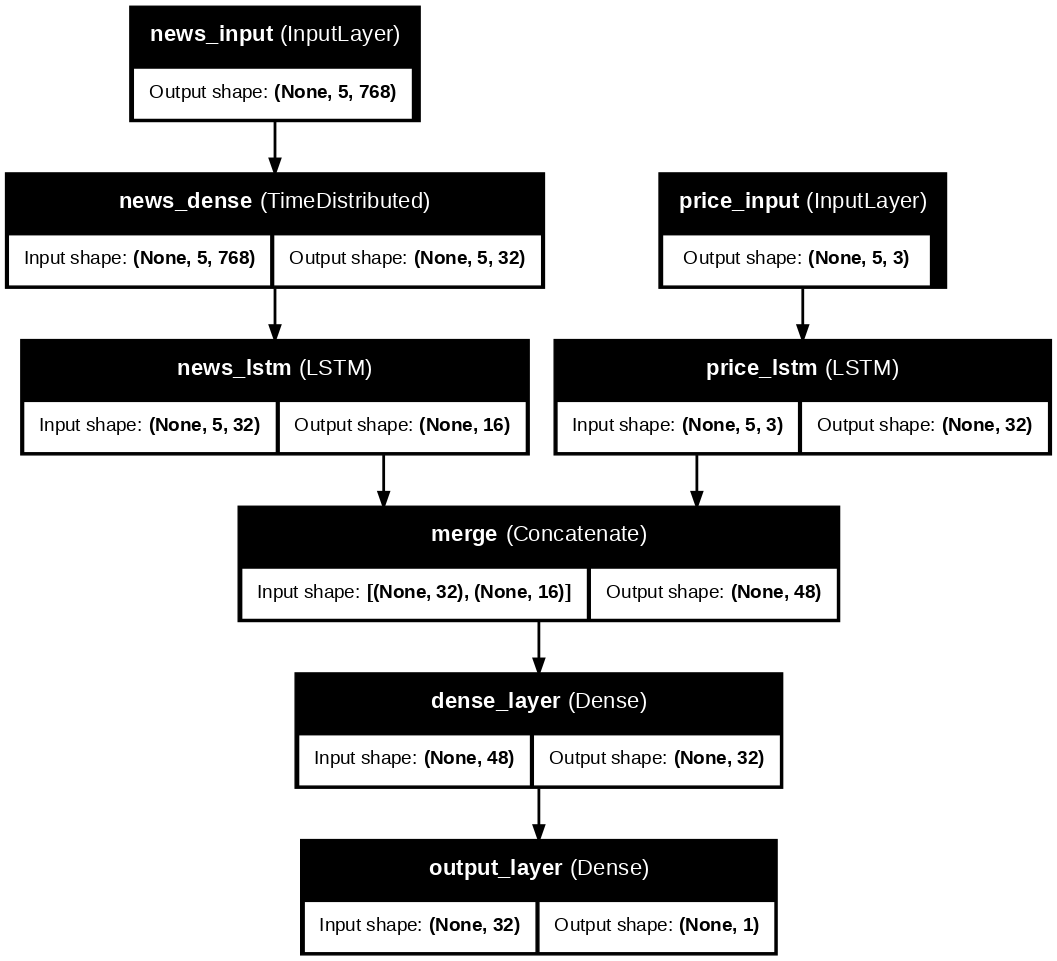

In [ ]:
# 可視化模型架構
plot_model(
    multimodal, # 模型
    to_file='./model.png', # 可視化圖儲存路徑
    show_shapes=True,  # 顯示維度
    show_layer_names=True, # 顯示模型名稱
    dpi=100 # 解析度
)

In [ ]:
# multimodal = Model(inputs=[price_input, news_input], outputs=output, name='multimodal_price_and_news')

history = multimodal.fit(
    [X_price_train_scaled, X_news_train], # X (股價, 新聞)，順序需對應模型定義時的結構
    y_train, # y (漲或跌)
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6402 - loss: 0.6609 - val_accuracy: 0.6508 - val_loss: 0.6523
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6640 - loss: 0.6287 - val_accuracy: 0.6508 - val_loss: 0.6586
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6616 - loss: 0.6261 - val_accuracy: 0.6508 - val_loss: 0.6859
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6634 - loss: 0.6145 - val_accuracy: 0.6508 - val_loss: 0.7001
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6857 - loss: 0.6157 - val_accuracy: 0.6508 - val_loss: 0.7341
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6921 - loss: 0.5885 - val_accuracy: 0.6508 - val_loss: 0.6591
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7235 - loss: 0.5549 - val_accuracy: 0.6508 - val_loss: 0.8180
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7756 - loss: 0.4866 - val_accuracy: 0.7288 - val_loss

# 結果評估

In [ ]:
loss, accuracy = multimodal.evaluate([X_price_test_scaled, X_news_test], y_test)
'準確度:', accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7908 - loss: 0.5722


('準確度:', 0.76902174949646)